### Exploratory Data Analysis

In this notebook we'll explore the different features that we will consider for battery chemistry classification. First, we'll highlight a few key features/ items from the raw dataset, and then spend the majority of the review on the processed datasets. Given the magnitude of the datasets, we'll conduct EDA by randomly sampling them to prevent any memory limitations looking at the entire dataset. Let's get started with a brief review of the raw data features and file types...


In [ ]:
# First, let's just show the variety of features in the raw dataset, that we'll need to either 
# exclude or rename as a unified feature set. The purpose of sharing this here is to demonstrate
# The breadth of diversity across our different datasources that will need to be rectified 
# Note this may take 10-30s to run.

# Importing packages
import pandas as pd
import random
import os 
import json
from pathlib import Path
from scipy.io import loadmat

def pull_features(input_dir):
    """
    Randomly sample files from each provider folder and read only the
    first row/header to report feature names. Special-cased readers by source:
      - cx2 : read_excel, pick first sheet with "Channel" in the name (fallback first sheet)
      - cs2 : whitespace-delimited text or csv (pd.read_csv with delim_whitespace=True)
      - INR : read_excel, pick sheet with "Channel" in name if exists, else first sheet
      - MIT : read_csv (first row)
      - PL : read_csv from nested structure
      - Stanford : read_csv from nested structure
      - Oxford : read_csv from nested structure
      - TU_Finland : read_csv from nested structure
      - ISU : read_json (top-level keys) - processed last due to load time
    """
    
    input_path = Path(input_dir)
    if not input_path.exists():
        raise ValueError(f"{input_dir} does not exist.")

    # helper to safely read a single-row header for pandas readers
    def _read_csv_header(fp, **kwargs):
        try:
            df = pd.read_csv(fp, nrows=1, **kwargs)
            return df.columns.tolist()
        except Exception:
            return None

    def _read_excel_header(fp, sheet=None):
        try:
            if sheet is None:
                df = pd.read_excel(fp, nrows=1)
            else:
                df = pd.read_excel(fp, sheet_name=sheet, nrows=1)
            return df.columns.tolist()
        except Exception:
            return None

    def _read_mat_header(fp):
        """Extract column names from TU_Finland/Oxford MAT files."""
        try:
            mat_data = loadmat(fp)
            
            # Check for Oxford format (Cell1-Cell8 keys)
            oxford_cells = [k for k in mat_data.keys() if k.startswith('Cell') and not k.startswith('__')]
            if oxford_cells:
                # Oxford format: Cell1 -> cyc#### -> C1ch/C1dc -> t, v, q, T
                # Return the typical fields from Oxford data structure
                return ['t', 'v', 'q', 'T', 'C1ch', 'C1dc', 'OCVch', 'OCVdc']
            
            # Check for TU_Finland format (table key)
            table = mat_data.get("table")
            if table is not None:
                # TU_Finland MAT files have a 'table' structure with named fields
                entries = table[0] if hasattr(table, '__iter__') else [table]
                if len(entries) > 0:
                    entry = entries[0]
                    fields = []
                    if hasattr(entry, 'dtype') and hasattr(entry.dtype, 'names'):
                        fields = list(entry.dtype.names)
                    else:
                        # Fallback to common TU_Finland fields
                        fields = ['Time', 'Voltage', 'Current', 'Temperature']
                    return fields
            
            return None
        except Exception:
            return None

    def _find_files_recursive(folder, max_depth=3):
        """Recursively find files up to max_depth levels deep, excluding readme files."""
        files = []
        def recurse(path, depth):
            if depth > max_depth:
                return
            try:
                for item in path.iterdir():
                    if item.is_file() and item.suffix.lower() in ('.csv', '.txt', '.xls', '.xlsx', '.json', '.mat'):
                        # Exclude readme files
                        if 'readme' not in item.name.lower():
                            files.append(item)
                    elif item.is_dir():
                        recurse(item, depth + 1)
            except PermissionError:
                pass
        recurse(folder, 0)
        return files

    # Separate ISU to process last
    top_folders = sorted([p for p in input_path.iterdir() if p.is_dir()])
    isu_folder = None
    other_folders = []
    
    for folder in top_folders:
        if "isu" in folder.name.lower():
            isu_folder = folder
        else:
            other_folders.append(folder)

    # Dictionary to store results
    results = {}
    file_types = {}

    # Process all folders except ISU first
    for folder in other_folders:
        provider = folder.name.lower()
        features = None
        file_ext = None
        
        # Branch by provider label - use if/elif to avoid processing same folder twice
        if "cx2" in provider or "cx" in provider:
            # CX2: Excel files with Channel sheets - stop after first success
            all_files = _find_files_recursive(folder)
            for fp in all_files:
                if fp.suffix.lower() in (".xls", ".xlsx") and not fp.name.startswith("~$"):
                    try:
                        xls = pd.ExcelFile(fp)
                        sheet = next((s for s in xls.sheet_names if "channel" in s.lower()), xls.sheet_names[0] if xls.sheet_names else None)
                        if sheet:
                            features = _read_excel_header(fp, sheet=sheet)
                            if features:
                                file_ext = fp.suffix.lower()
                                break
                    except Exception:
                        continue

        elif "cs2" in provider or "cs" in provider:
            # CS2: whitespace-delimited text files - stop after first success
            all_files = _find_files_recursive(folder)
            for fp in all_files:
                if fp.suffix.lower() in (".txt", ".csv"):
                    features = _read_csv_header(fp, delim_whitespace=True)
                    if features is None:
                        features = _read_csv_header(fp)
                    if features:
                        file_ext = fp.suffix.lower()
                        break

        elif "inr" in provider:
            # INR: Excel files, prefer sheet with "Channel" in name
            all_files = _find_files_recursive(folder)
            for fp in all_files:
                if fp.suffix.lower() in (".xls", ".xlsx") and not fp.name.startswith("~$"):
                    try:
                        xls = pd.ExcelFile(fp)
                        sheet = next((s for s in xls.sheet_names if "channel" in s.lower()), xls.sheet_names[0] if xls.sheet_names else None)
                        if sheet:
                            features = _read_excel_header(fp, sheet=sheet)
                            if features:
                                file_ext = fp.suffix.lower()
                                break
                    except Exception:
                        continue

        elif "mit" in provider:
            # MIT: CSV format - stop after first success
            all_files = _find_files_recursive(folder)
            for fp in all_files:
                if fp.suffix.lower() in (".csv", ".txt"):
                    features = _read_csv_header(fp)
                    if features:
                        file_ext = fp.suffix.lower()
                        break

        elif "pl" in provider:
            # PL: CSV files in nested structure
            all_files = _find_files_recursive(folder)
            for fp in all_files:
                if fp.suffix.lower() in (".csv", ".txt"):
                    features = _read_csv_header(fp)
                    if features:
                        file_ext = fp.suffix.lower()
                        break

        elif "stanford" in provider:
            # Stanford: Excel files in nested structure
            all_files = _find_files_recursive(folder)
            for fp in all_files:
                if fp.suffix.lower() in (".xls", ".xlsx") and not fp.name.startswith("~$"):
                    try:
                        features = _read_excel_header(fp)
                        if features:
                            file_ext = fp.suffix.lower()
                            break
                    except Exception:
                        continue

        elif "oxford" in provider:
            # Oxford: MAT files
            all_files = _find_files_recursive(folder)
            for fp in all_files:
                if fp.suffix.lower() == ".mat":
                    features = _read_mat_header(fp)
                    if features:
                        file_ext = fp.suffix.lower()
                        break

        elif "finland" in provider or "tu_finland" in provider:
            # TU_Finland: MAT files
            all_files = _find_files_recursive(folder)
            for fp in all_files:
                if fp.suffix.lower() == ".mat" and 'ocv' not in fp.name.lower():
                    features = _read_mat_header(fp)
                    if features:
                        file_ext = fp.suffix.lower()
                        break

        # Store results
        if features:
            results[folder.name] = features
            file_types[folder.name] = file_ext
        else:
            results[folder.name] = None
            file_types[folder.name] = None

    # Process ISU last due to JSON load time
    if isu_folder:
        features = None
        file_ext = None
        all_files = _find_files_recursive(isu_folder)
        json_files = [fp for fp in all_files if fp.suffix.lower() == ".json"]
        
        if json_files:
            # Only read one JSON file
            fp = json_files[0]
            try:
                with open(fp, "r", encoding="utf8") as fh:
                    # ISU files have double-encoded JSON - need to load twice
                    j = json.loads(json.load(fh))
                # Extract keys from the cycling data structure
                if isinstance(j, dict):
                    # Look for the main data keys (QV_charge, QV_discharge, etc.)
                    features = list(j.keys())
                    file_ext = fp.suffix.lower()
                elif isinstance(j, list) and len(j) > 0:
                    if isinstance(j[0], dict):
                        features = list(j[0].keys())
                        file_ext = fp.suffix.lower()
            except Exception as e:
                print(f"  Failed to read JSON {fp.name}: {e}")
        
        if features:
            results[isu_folder.name] = features
            file_types[isu_folder.name] = file_ext
        else:
            results[isu_folder.name] = None
            file_types[isu_folder.name] = None

    return results, file_types


def print_detailed_features(results):
    """Print detailed feature listings for each provider."""
    print("=" * 80)
    print("DETAILED FEATURE LISTINGS")
    print("=" * 80)
    for provider_name, feature_list in results.items():
        if feature_list:
            print(f"\nExample Features in {provider_name} Datafiles:")
            print(feature_list)
        else:
            print(f"\nNo readable feature header found for {provider_name}")


def print_feature_summary(results):
    """Print summary of feature counts for each provider."""
    print("=" * 80)
    print("SUMMARY")
    print("=" * 80)
    for provider_name, feature_list in results.items():
        if feature_list:
            print(f"{provider_name} files contain {len(feature_list)} features")
        else:
            print(f"{provider_name} files contain 0 features (no readable data)")


def print_file_types(file_types):
    """Print file extension types for each provider."""
    print("=" * 80)
    print("FILE TYPES BY PROVIDER")
    print("=" * 80)
    for provider_name, ext in file_types.items():
        if ext:
            print(f"{provider_name}: {ext}")
        else:
            print(f"{provider_name}: No file type detected")


# Load feature data from raw data files
feature_results, file_type_results = pull_features("../assets/raw")

C:\Users\MJone\AppData\Local\Temp\ipykernel_36064\924594357.py:36: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(fp, nrows=1, **kwargs)


In [2]:
# Let's see the number of features per data provider:  
print_feature_summary(feature_results)

SUMMARY
CS2 files contain 66 features
CX2 files contain 17 features
INR files contain 17 features
MIT files contain 10 features
Oxford files contain 8 features
PL files contain 8 features
Stanford files contain 7 features
TU_Finland files contain 5 features
ISU files contain 7 features


In [3]:
# Now let's see the file extension types used by each data provider:
print_file_types(file_type_results)

FILE TYPES BY PROVIDER
CS2: .txt
CX2: .xlsx
INR: .xls
MIT: .csv
Oxford: .mat
PL: .csv
Stanford: .xlsx
TU_Finland: .mat
ISU: .json


In [4]:
# Finally Let's Examine the different features according to each data source: 
print_detailed_features(feature_results)

DETAILED FEATURE LISTINGS

Example Features in CS2 Datafiles:
['Time', 'Status', 'code', 'Status.1', 'category', 'Status.2', 'color', 'Pgm', 'code.1', 'Pgm.1', 'step', 'Pgm.2', 'para', 'Pgm.3', 'cycle', 'mV', 'mA', 'Temperature', 'Duration', 'Charge', 'count', 'Discharge', 'count.1', 'Capacity', 'Analog', 'input', '1', 'Analog.1', 'input.1', '2', 'Analog.2', 'input.2', '3', 'Analog.3', 'input.3', '4', 'Digital', 'input.4', '1.1', 'Digital.1', 'input.5', '2.1', 'Digital.2', 'input.6', '3.1', 'Digital.3', 'input.7', '4.1', 'Digital.4', 'output', '1.2', 'Digital.5', 'output.1', '2.2', 'Digital.6', 'output.2', '3.2', 'Digital.7', 'output.3', '4.2', 'Analog.4', 'output.4', '1.3', 'Analog.5', 'output.5', '2.3']

Example Features in CX2 Datafiles:
['Data_Point', 'Test_Time(s)', 'Date_Time', 'Step_Time(s)', 'Step_Index', 'Cycle_Index', 'Current(A)', 'Voltage(V)', 'Charge_Capacity(Ah)', 'Discharge_Capacity(Ah)', 'Charge_Energy(Wh)', 'Discharge_Energy(Wh)', 'dV/dt(V/s)', 'Internal_Resistance(Ohm

#### Discussion:

From the brief review, it should be clear that a lot of data alignment is required before we can begin modeling. The data processing scripts that manage this are held in _src/parser_. We won't go through all of the data processing but in short, we have to be able to reach across 6 fundamentally different data structures, and re-align naming convention across each group. While some tests contain many features, the uniform set across all apears to be current, voltage, temperature, and test duration. We will also impute additional features like C-rate, and then drop the remaining features.

To close out the raw data review, let's see a brief voltage vs. time trace from one of the CX files:

---


Reading: CX2_16_10_14_11.xlsx
Reading sheet: Channel_1-006
Columns: ['Data_Point', 'Test_Time(s)', 'Date_Time', 'Step_Time(s)', 'Step_Index', 'Cycle_Index', 'Current(A)', 'Voltage(V)', 'Charge_Capacity(Ah)', 'Discharge_Capacity(Ah)', 'Charge_Energy(Wh)', 'Discharge_Energy(Wh)', 'dV/dt(V/s)', 'Internal_Resistance(Ohm)', 'Is_FC_Data', 'AC_Impedance(Ohm)', 'ACI_Phase_Angle(Deg)']
Shape: (21540, 17)


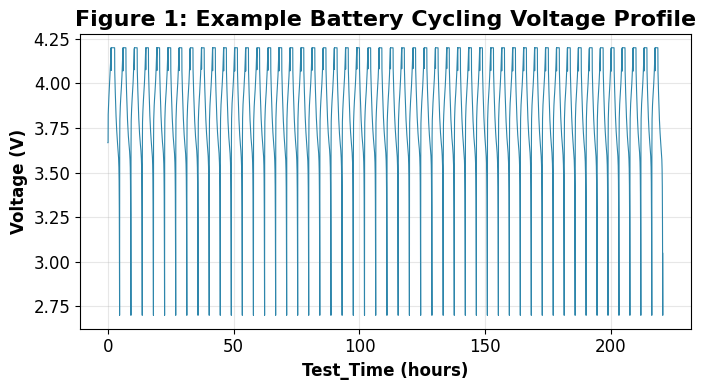

In [5]:
# Let's visualize a voltage vs. time trace from a CX2 file to see the raw cycling data
import matplotlib.pyplot as plt

report_plot = True

# Find a CX2 file
cx2_path = Path("../assets/raw_data/CX2")
cx2_files = [f for f in cx2_path.rglob("*.xls*") if not f.name.startswith("~$")]

if cx2_files:
    # Read the first CX2 file
    sample_file = cx2_files[0]
    print(f"Reading: {sample_file.name}")
    
    # CX2 files are Excel files with Channel sheets
    xls = pd.ExcelFile(sample_file)
    sheet_name = next((s for s in xls.sheet_names if "channel" in s.lower()), xls.sheet_names[0])
    print(f"Reading sheet: {sheet_name}")
    
    df_cx2 = pd.read_excel(sample_file, sheet_name=sheet_name)
    
    print(f"Columns: {df_cx2.columns.tolist()}")
    print(f"Shape: {df_cx2.shape}")
    
    # Plot Voltage(V) vs Test_Time(s)
    if 'Test_Time(s)' in df_cx2.columns and 'Voltage(V)' in df_cx2.columns:
        fig, ax = plt.subplots(figsize=(7, 4))
        
        # Convert time to hours for better readability
        time_hours = df_cx2['Test_Time(s)'].values / 3600
        
        ax.plot(time_hours, df_cx2['Voltage(V)'].values, linewidth=0.8, color='#2E86AB')
        ax.set_xlabel('Test_Time (hours)', fontsize=12, fontweight = 'bold')
        ax.set_ylabel('Voltage (V)', fontsize=12, fontweight = 'bold')
        ax.tick_params(axis='both', which='major', labelsize=12)

        if report_plot == True: 
            ax.set_title(f"Figure 1: Example Battery Cycling Voltage Profile", fontsize=16, fontweight='bold')            
        else: 
            ax.set_title(f"Voltage vs. Time for {sample_file.name}", fontsize=16, fontweight='bold')
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
    else:
        print(f"Could not find 'Test_Time(s)' or 'Voltage(V)' columns")
        print(f"Available columns: {df_cx2.columns.tolist()}")
else:
    print("No CX2 files found")

Now, let's switch to the processed dataset. We'll focus on this for two reasons:

1. The feature naming varied between different academic providers, so we needed to align on naming convention. (Ex.voltage_v, is considered sometimes named listed as Voltage, or Potential)
2. There were many features that we excluded upfront due to irrelavance for chemistry classification such as cycler_id, channel_no, or potential sources for data leakage, like energy_throughput.


In [6]:

def load_sample_data(): 
    # set paths
    nb_dir = Path.cwd() if "__file__" not in globals() else Path(__file__).parent
    processed_root = (nb_dir.parent / "assets" / "processed").resolve()

    #set random seed & define relative path
    random.seed(42)

    #walk through chemistry directorys, sample up to 3 cells per chemistry, and read in charge_agg and discharge_agg csvs
    chem_dirs = [chem for chem in processed_root.iterdir() if chem.is_dir()]
    charge_dfs = []
    discharge_dfs = []

    for chem_dir in chem_dirs:
        cell_dirs = [cell_dir for cell_dir in chem_dir.iterdir() if cell_dir.is_dir()]
        if not cell_dirs:
            print(f"No cell folders for chemistry: {chem_dir.name}")
            continue
        sampled = random.sample(cell_dirs, min(5, len(cell_dirs)))
        print(f"Chemistry {chem_dir.name}: sampling {len(sampled)} cells")
        for cell in sampled:
            csv_files = list(cell.glob("*.csv"))
            if not csv_files:
                print(f"  No CSVs in {cell}")
                continue
            for fp in csv_files:
                name = fp.name.lower()
                try:
                    df = pd.read_csv(fp)
                except Exception as e:
                    print(f"  Failed to read {fp}: {e}")
                    continue
                if "discharge_agg" in name:
                    discharge_dfs.append(df)
                elif "charge_agg" in name:
                    charge_dfs.append(df)
                else:
                    # skip files that are neither charge_agg nor discharge_agg
                    continue

    # Build final concatenated DataFrames (one row per original row across sampled files)
    charge_df = pd.concat(charge_dfs, ignore_index=True) if charge_dfs else pd.DataFrame()
    discharge_df = pd.concat(discharge_dfs, ignore_index=True) if discharge_dfs else pd.DataFrame()

    print(f"Total charge rows: {len(charge_df)}, total discharge rows: {len(discharge_df)}")
    return charge_df, discharge_df

charge_df, discharge_df = load_sample_data()

Chemistry NMC: sampling 5 cells
Chemistry LCO: sampling 5 cells
Chemistry LFP: sampling 5 cells
Chemistry NCA: sampling 5 cells
Total charge rows: 145900, total discharge rows: 145900


Now that the dataframes are loaded, let's compare high level features of the different chemistries in charge and discharge conditions. We'll start with violin plots to show the spread in voltage, c-rate, and temperature. We will also display elapsed time to demonstrate how some batteries were aged for different periods of time.


['NMC', 'LCO', 'LFP', 'NCA']


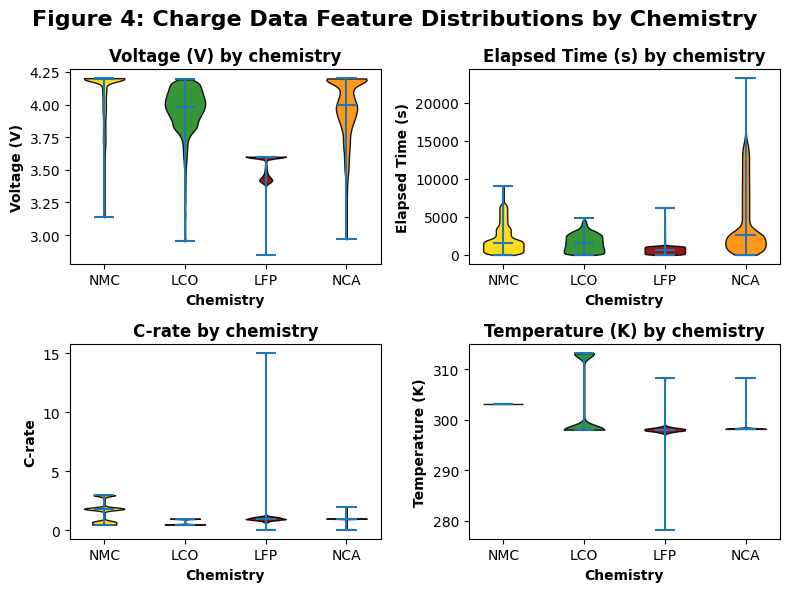

In [10]:
import numpy as np


def plot_violin_small_multiples(df, features_list, sup_title):
    """This function creates violin plots for specified features across different chemistries.
    Inputs: df (pandas DataFrame), features_list (list of strings)
    Outputs: Displays violin plots for each feature in features_list."""


    chemistries = list(df.chemistry.unique())
    print(chemistries)
    df = df[df["chemistry"].isin(chemistries)].copy()

    # Set num cols based on feature qty
    num_vars = len(features_list)
    ncols = int(np.ceil(num_vars / 2))
    nrows = 2

    # Create subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3*nrows), sharey=False)
    axes = axes.flatten() 

    if num_vars == 1:
        axes = [axes]

    for ax, var in zip(axes, features_list):

        # Collect data for each chemistry in fixed order
        plot_data = []
        valid_chemistries = []
        for chem in chemistries:
            subset = df[df["chemistry"] == chem][var].copy()
            # Convert to numeric, coercing errors to NaN
            subset = pd.to_numeric(subset, errors='coerce').dropna()
            # Need at least 2 data points for violin plot
            if len(subset) >= 2:
                plot_data.append(subset.values)
                valid_chemistries.append(chem)

        # Skip if no valid data
        if not plot_data:
            ax.text(0.5, 0.5, f'No data for {var}', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_xticks([])
            continue

        # Create violin plot
        parts = ax.violinplot(
            plot_data,
            positions=np.arange(len(valid_chemistries)),
            showmeans=False,
            showmedians=True,
            showextrema=True
        )

        # Specify Color
        if len(valid_chemistries) != 4: 
            for pc in parts['bodies']:
                pc.set_facecolor('#1f77b4')
                pc.set_alpha(0.5)
        else: 
            colors = ['#FFD700', '#228B22', '#8B0000', '#FF8C00']
            for pc, color in zip(parts['bodies'], colors):
                pc.set_facecolor(color)
                pc.set_alpha(0.9)
                pc.set_edgecolor("black")
                pc.set_linewidth(1.0)

        # Configure axes
        if var == "c_rate": label_var = "C-rate"
        elif var == "voltage_v": 
            label_var = "Voltage (V)"
        elif var == "elapsed_time_s":
            label_var = "Elapsed Time (s)"
        elif var == "temperature_k":
            label_var = "Temperature (K)"

        ax.set_title(f"{label_var} by chemistry", fontweight ='bold')
        ax.set_xticks(np.arange(len(valid_chemistries)))
        ax.set_xticklabels(valid_chemistries)
        ax.set_xlabel("Chemistry", fontsize=10, fontweight='bold')
        ax.set_ylabel(label_var, fontsize=10, fontweight='bold')

    plt.suptitle(sup_title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


#Plot for charge dataframe 
plot_violin_small_multiples(charge_df, 
                            features_list=["voltage_v", "elapsed_time_s", "c_rate", "temperature_k"], 
                            sup_title="Figure 4: Charge Data Feature Distributions by Chemistry",
                            )




**A few notable observations:**<br>
Voltage:

- First, on the voltage plot, we can see LFP has a very distinct voltage range, while the other chemistries are share similar ranges.
- Second, the distribution of voltage, reflective of the nominal value during charging varies significantly amoung the chemistries. LCO's nominal volage is close to 3.9V, whereas our NCA and NMC nominal voltages skew toward 4.2V (with a large variation band for NCA), and LFP skews to 3.4V <br>

C-rate:

- NMC appears to have a large spread in c-rates considered in our dataset. NCA appears to have similar ranges, however the majority of test conditions lie at the 1.0C condition. LFP testing appears exclusively at 1C, and LCO varies between 1C and C/2. Given the C-rate implications for voltage curve offsets, this could introduce bias in our battery classification model(s).

Temperature:

- Most chemistries appear to be tested at roughly the same room temperature conditions, with a few outliers at ~10degC and 30degC.
- In practical application in a power plant validation test, each battery will be tested at the same temperature in a process known as "thermal soaking". The outlier LCO and NCA cells may cause some problems in prediction robustness, and the relative rigidity of test temperatures shown above will restrict our model deployment in a plant to specific operating thermal conditions. Since the temperature is approximately standard plant operating conditions (25degC), this is not a signficant setback.

Test Time:
This feature demonstrates the differences in the period under which each cell was cycled.

Now let's explore the variations we see in the discharge condition. We would expect them to be similar, with differences reflective of hysteresis in the cells.


['NMC', 'LCO', 'LFP', 'NCA']


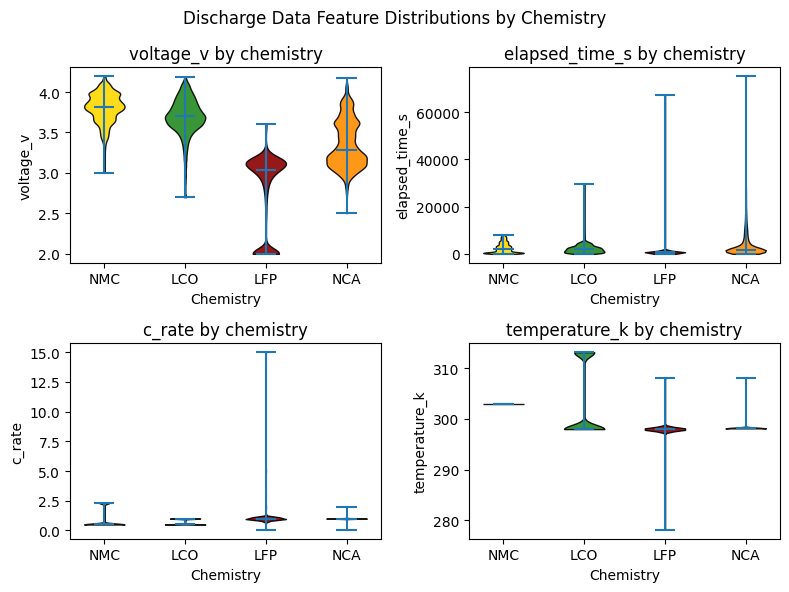

In [21]:
#Plot for discharge dataframe
plot_violin_small_multiples(discharge_df, 
                            features_list=["voltage_v", "elapsed_time_s", "c_rate", "temperature_k"], 
                            sup_title="Discharge Data Feature Distributions by Chemistry",
                            )

Again we see differences in the nominal voltage across chemistries, though there spread is much more consistent. Because of the test operating conditions in a fixed thermal chamber & cycler, the c-rate and temperature features are relatively unchanged.

Now let's examine a single charge/discharge curve plot for each of the different chemistries. C-rate will influence the curvature, but this will help us understand the relative differences in shape between the battery chemistries, especially along an intersectional region:


LFP Discharge: Plotted 100 points from MIT_20180412_cell_39_processed
NMC Discharge: Plotted 100 points from G20C2
LCO Discharge: Plotted 100 points from Oxford_Cell5
NCA Discharge: Plotted 100 points from nca_k6_278k
NCA Discharge: Plotted 100 points from nca_k6_278k


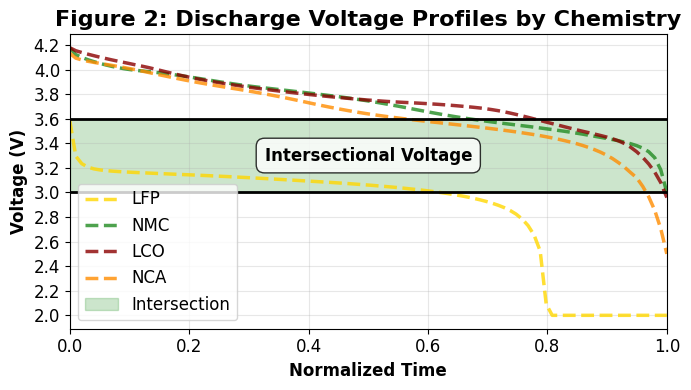

In [78]:
# Plot charge and discharge curves for each chemistry overlaid
def plot_overlaid_chemistry_curves(intersect_min=3.0, intersect_max=3.6):
    """Plot one random discharge curve for each chemistry."""
    
    # Set paths
    processed_root = Path("../assets/processed").resolve()
    
    chemistries = ['LFP', 'NMC', 'LCO', 'NCA']
    colors = {'LFP': '#FFD700', 'NMC': '#228B22', 'LCO': '#8B0000', 'NCA': "#FF8C00FF"}
    
    fig, ax = plt.subplots(figsize=(7, 4))
    
    random.seed(6)
    
    for chem in chemistries:
        chem_path = processed_root / chem
        
        if not chem_path.exists():
            print(f"Chemistry folder not found: {chem}")
            continue
        
        # Get all cell directories
        cell_dirs = [d for d in chem_path.iterdir() if d.is_dir()]
        
        if not cell_dirs:
            print(f"No cells found for {chem}")
            continue
        
        # Randomly sample one cell
        sample_cell = random.choice(cell_dirs)
        
        # Process discharge file
        discharge_files = [f for f in sample_cell.glob("*.csv") 
                          if "discharge" in f.name.lower() 
                          and "error" not in f.name.lower()]
        
        if discharge_files:
            try:
                df_discharge = pd.read_csv(discharge_files[0])
                
                # Filter to first cycle only if there are at least 2 unique cycles
                if 'cycle_index' in df_discharge.columns:
                    unique_cycles = df_discharge['cycle_index'].unique()
                    if len(unique_cycles) >= 2:
                        first_cycle = unique_cycles[0]
                        df_discharge = df_discharge[df_discharge['cycle_index'] == first_cycle]
                
                if 'voltage_v' in df_discharge.columns:
                    voltage = pd.to_numeric(df_discharge['voltage_v'], errors='coerce').dropna()
                    
                    if len(voltage) > 1:
                        if 'normalized_time' in df_discharge.columns:
                            time = pd.to_numeric(df_discharge['normalized_time'], errors='coerce')[:len(voltage)]
                        else:
                            time = np.arange(len(voltage))
                        
                        ax.plot(time, voltage.values, 
                                color=colors.get(chem, '#1f77b4'),
                                linestyle='--',
                                linewidth=2.5, alpha=0.8, label=chem)
                        
                        print(f"{chem} Discharge: Plotted {len(voltage)} points from {sample_cell.name}")
            except Exception as e:
                print(f"Error reading discharge file for {chem}: {e}")
    
    # Configure plot
    ax.set_xlabel("Normalized Time", fontsize=12, fontweight='bold')
    ax.set_ylabel("Voltage (V)", fontsize=12, fontweight='bold')
    ax.set_title("Figure 2: Discharge Voltage Profiles by Chemistry", fontsize=16, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.set_yticks(np.arange(2, 4.4, 0.2))
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Add horizontal lines at 3.0V and 3.6V
    ax.axhline(y=intersect_min, color='black', linewidth=2, linestyle='-', zorder=5)
    ax.axhline(y=intersect_max, color='black', linewidth=2, linestyle='-', zorder=5)
    
    # Add green shaded overlay for intersectional voltage window
    ax.fill_between(ax.get_xlim(), intersect_min, intersect_max, color='green', alpha=0.2, zorder=1, label='Intersection') 
    
    # Add text label in the middle of the intersectional voltage window
    xlim = ax.get_xlim()
    x_center = (xlim[0] + xlim[1]) / 2
    ax.text(x_center, (intersect_min + intersect_max)/2, 'Intersectional Voltage', fontsize=12, color='black', 
            ha='center', va='center', fontweight='bold', bbox=dict(boxstyle='round,pad=0.5', 
            facecolor='white', edgecolor='black', alpha=0.8))
    
    ax.legend(fontsize=12, loc='best')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot overlaid curves
plot_overlaid_chemistry_curves()



For one last figure, let's compare the min, max, and nominal voltages using grouped bar plots....


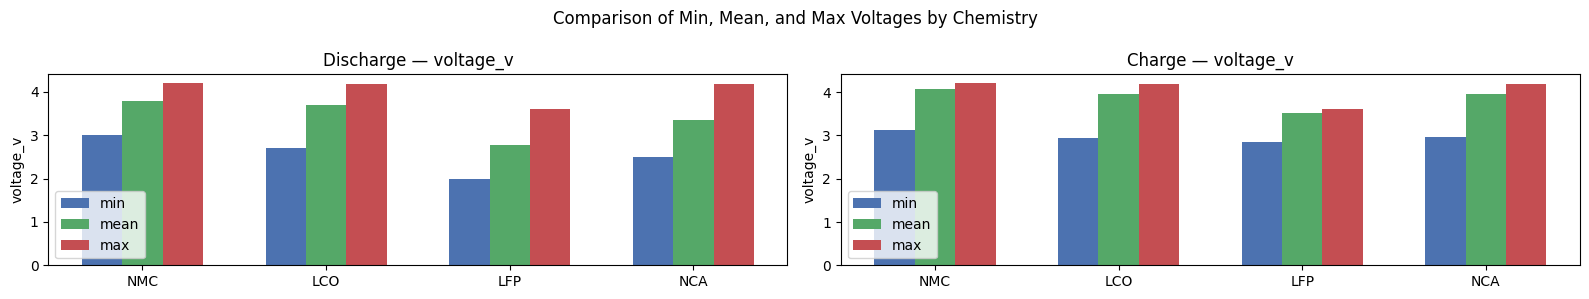

In [49]:
def compute_feature_stats(df, chemistry_list, input_feature, chemistry_col="chemistry"):
    feature_stats = {}
    for chemistry in chemistry_list:
        chem_data = df[df[chemistry_col] == chemistry][input_feature]
        feature_stats[chemistry] = {
            "min": chem_data.min(),
            "mean": chem_data.mean(),
            "max": chem_data.max()
        }
    return feature_stats


def bar_plot_features(chemistry_list, input_charge_df, input_discharge_df, input_feature, input_title="Feature Comparison by Chemistry"): 
    # plotting
    n = len(chemistry_list)
    x = np.arange(n)
    width = 0.22

    fig, axes = plt.subplots(1, 2, figsize=(4*n, 3))

    # Discharge subplot (left)
    mins = [input_discharge_df[c]["min"] for c in chemistry_list]
    means = [input_discharge_df[c]["mean"] for c in chemistry_list]
    maxs = [input_discharge_df[c]["max"] for c in chemistry_list]

    axes[0].bar(x - width, mins, width, label="min", color="#4C72B0")
    axes[0].bar(x, means, width, label="mean", color="#55A868")
    axes[0].bar(x + width, maxs, width, label="max", color="#C44E52")
    axes[0].set_title(f"Discharge — {input_feature}")
    axes[0].legend(loc='lower left')
    axes[0].set_ylabel(input_feature)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(chemistry_list, rotation=0)

    # Charge subplot (right)
    mins = [input_charge_df[c]["min"] for c in chemistry_list]
    means = [input_charge_df[c]["mean"] for c in chemistry_list]
    maxs = [input_charge_df[c]["max"] for c in chemistry_list]

    axes[1].bar(x - width, mins, width, label="min", color="#4C72B0")
    axes[1].bar(x, means, width, label="mean", color="#55A868")
    axes[1].bar(x + width, maxs, width, label="max", color="#C44E52")
    axes[1].set_title(f"Charge — {input_feature}")
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(chemistry_list, rotation=0)
    axes[1].set_ylabel(input_feature)
    axes[1].legend(loc='lower left')

    plt.suptitle(input_title)
    plt.tight_layout()
    plt.show()


desired_features = ["voltage_v"]

chemistry_list = charge_df["chemistry"].unique().tolist()
charge_feature_stats = {feature: compute_feature_stats(charge_df, 
                                                       chemistry_list, 
                                                       feature) for feature in desired_features}

discharge_feature_stats = {feature: compute_feature_stats(discharge_df, 
                                                          chemistry_list, 
                                                          feature) for feature in desired_features}

feature = "voltage_v"

bar_plot_features(chemistry_list, 
             charge_feature_stats[feature], 
             discharge_feature_stats[feature], 
             feature,
             input_title="Comparison of Min, Mean, and Max Voltages by Chemistry")

Here we can better compare the slight variations in the min, max, and nominal voltages for each chemistry. It's important to note that during charge condition, the LFP battery nominal voltage is very close to the max operating voltage.
